# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

from utils.gaussian_processes.gp_model import GPModel

2023-02-08 16:12:21.501578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 16:12:21.845853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 16:12:21.845879: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-08 16:12:21.906641: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-08 16:12:23.655607: W tensorflow/stream_executor/pla

# Data

In [2]:
# Load the data
# Load the data from the Scripps CO2 program website. 
co2_df = pd.read_csv(
    # Source: https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
    './monthly_in_situ_co2_mlo.csv', 
    header=3, # Data starts here
    skiprows=[4, 5], # Headers consist of multiple rows
    usecols=[3, 4], # Only keep the 'Date' and 'CO2' columns
    na_values='-99.99',  # NaNs are denoted as '-99.99'
    dtype=np.float64
)

# Drop missing values
co2_df.dropna(inplace=True)
# Remove whitespace from column names
co2_df.rename(columns=lambda x: x.strip(), inplace=True)


# Split the data into observed and to predict
date_split_predict = 2010
df_observed = co2_df[co2_df.Date < date_split_predict]
print('{} measurements in the observed set'.format(len(df_observed)))
df_predict = co2_df[co2_df.Date >= date_split_predict]
print('{} measurements in the test set'.format(len(df_predict)))

617 measurements in the observed set
133 measurements in the test set


In [3]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 624 to 756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    133 non-null    float64
 1   CO2     133 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


# Gaussian Process

In [4]:
gp_model = GPModel()

In [5]:
gp_model.fit(df_observed=df_observed, x_col="Date", y_col="CO2", epochs=1000)

from dataloader.load_regression_data import RegressionDataGenerator

2023-02-08 16:12:26.935144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-08 16:12:26.935186: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 16:12:26.935214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-02-08 16:12:26.935577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


100%|██████████| 1000/1000 [00:36<00:00, 27.32it/s]


# DataGenerator

In [6]:
data_generator = RegressionDataGenerator(gp_model=gp_model,
                                         df_predict=df_predict)

(<Figure size 800x500 with 1 Axes>, <AxesSubplot: >)

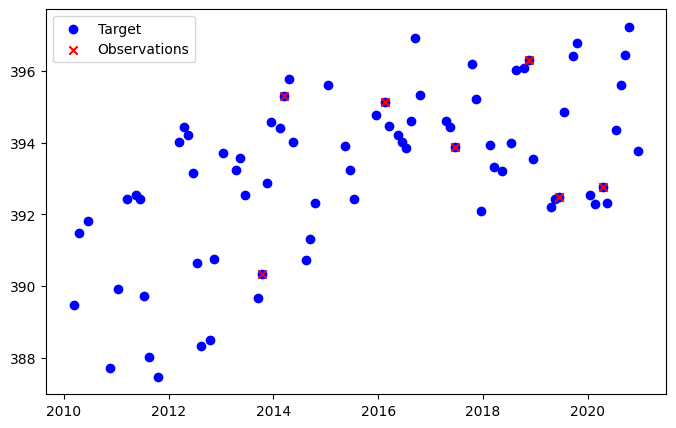

In [7]:
data_generator.plot_first_elt_of_random_batch()

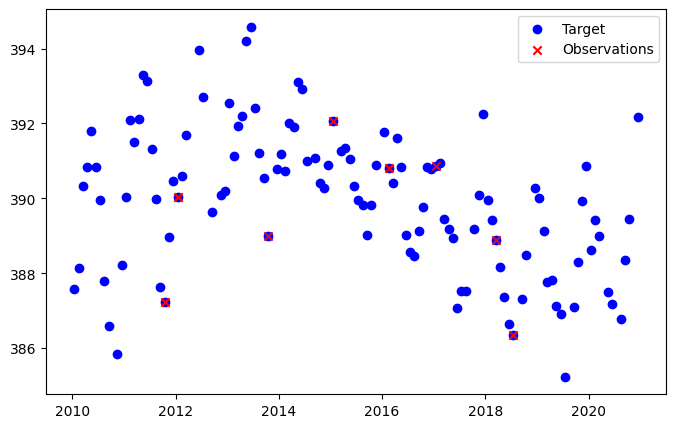

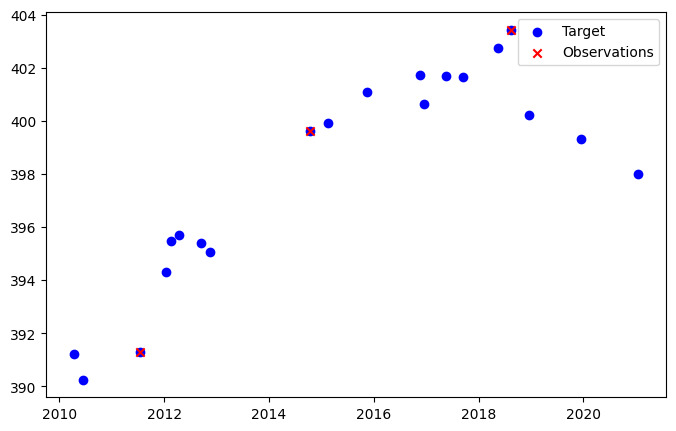

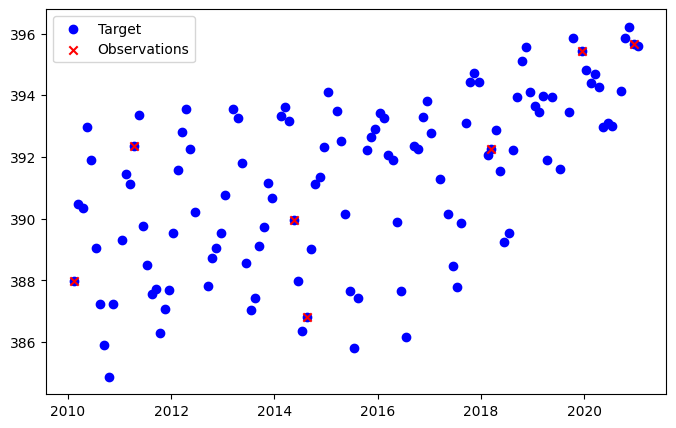

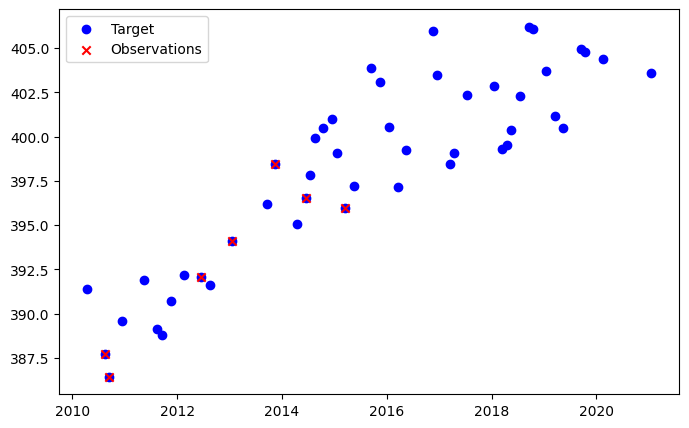

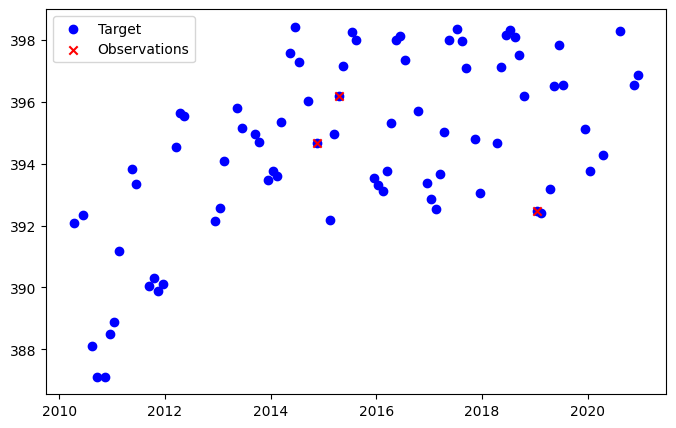

In [8]:
for (context_x, context_y, target_x), target_y in data_generator.train_ds.take(5):
    RegressionDataGenerator.plot_first_elt_of_batch(context_x, context_y, target_x, target_y)